(54, 160, 3)


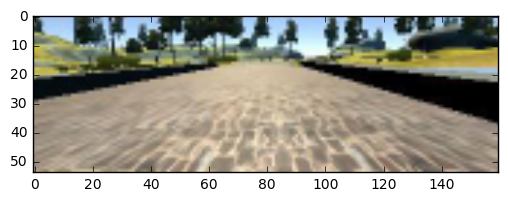

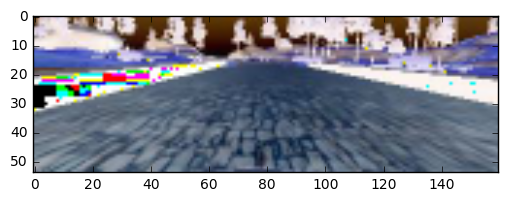

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from math import floor, ceil
import numpy as np
%matplotlib inline

#Load driving log:

driving_log = pd.read_csv(
    'driving_log.csv',
    names=['Center','Left','Right','Steering Angle','Throttle','Break','Speed'],
    header=None,
    skiprows=1)

#Load and preprocess images:

def load_image(path, flip=False):
    image = cv2.imread(path)
    #Lower resolution, still doesn't affect network's performance
    image = cv2.resize(image, (0,0), fx=0.5, fy=0.5)
    #Convert to RGB
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #Normalize image
    #image = image/255.
    #Crop image, remove sky and the bottom part. Leave some of both for bumpy sections.
    image = image[floor(image.shape[0]*0.2):floor(image.shape[0]*0.88),:,:]
    #Flip image
    if flip:
        #image = np.asarray(image)[:,::-1,:]
        image = cv2.flip(image, 1)
    
    return image

image = load_image(driving_log['Left'][0].strip(), True)
print (image.shape)
plt.figure()
plt.imshow(image)

#center_images = np.array([load_image(path.strip()) for path in driving_log['Center']], dtype=np.float32)
#left_images = np.array([load_image(path.strip()) for path in driving_log['Left']], dtype=np.float32)
#right_images = np.array([load_image(path.strip()) for path in driving_log['Right']], dtype=np.float32)

In [120]:
def generator_train(data, batch_size=50):
    print (batch_size)
    while True:    
    
        X_Train_list, Y_Train_list = [], []
        counter = 0
        #for counter in range(batch_size):
        while counter < batch_size:
            idx = np.random.randint(len(data))

            #Half the time we'll skip image if angle == 0.0.
            #We do this to rebalance the dataset, as more than half of the images
            #have 0.0 as steering angle
            if data['Steering Angle'][idx] == 0.0 and np.random.randint(2) == 0:                
                continue
            else:
                #Each camera image has a probability of 33% of being chosen
                #For the left and right camera, the steering angle needs to be
                #compensated (+0.25/-0.25)
                image_choice = np.random.randint(3)
                if image_choice == 0:
                    X_Train_list.append(data['Center'][idx])
                    Y_Train_list.append(data['Steering Angle'][idx])
                elif image_choice == 1:
                    X_Train_list.append(data['Left'][idx])
                    Y_Train_list.append(data['Steering Angle'][idx] +.25)
                else:
                    X_Train_list.append(data['Right'][idx])
                    Y_Train_list.append(data['Steering Angle'][idx] -.25)
        
                counter += 1

        X_Train_regular = [load_image(path.strip()) for path in X_Train_list[0:ceil(batch_size/2.0)]]        
        Y_Train_regular = [angle for angle in Y_Train_list[0:ceil(batch_size/2.0)]]
        #We'll flip half the batch
        X_Train_flipped = [load_image(path.strip(), True) for path in X_Train_list[ceil(batch_size/2.0):]]
        Y_Train_flipped = [-angle for angle in Y_Train_list[ceil(batch_size/2.0):]]
        X_Train = np.array(X_Train_regular + X_Train_flipped)
        Y_Train = np.array(Y_Train_regular + Y_Train_flipped)
                
        yield X_Train, Y_Train
    

10
[-0.03127411  0.01391724  0.114288    0.25        0.1670138   0.5281274
  0.25       -0.25       -0.00434871 -0.25      ]


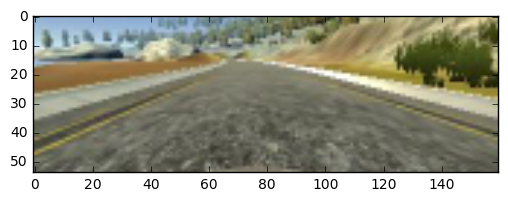

In [121]:
gen = generator_train(driving_log, batch_size=10)
image, angle = next(gen)

plt.figure()
plt.imshow(image[0])

print (angle)

